In [88]:
#posterior import
import os
import pandas as pd
import numpy as np
cores = ['DF', 'EDC', 'EDML', 'WDC']
posterior_output = {}

for core in cores:
    if os.name == 'nt':
        core_df_path = f"E:/GitHub/BICC/Paleochrono/BICC2025/{core}/output.txt"
    elif os.name == 'posix':
        core_df_path = f"/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/{core}/output.txt"
    posterior_core_df = pd.read_csv(core_df_path, delimiter="\t", comment="#", names=["depth", "ice_age", "sigma_ice_age", "air_age", "sigma_air_age", "sigma_delta_age", "deporate", "sigma_deporate", "thinning", "sigma_thinning", "LID", "sigma_LID", "delta_depth", "sigma_delta_depth", "deporate_model", "sigma_deporate_model", "thinning_model", "sigma_thinning_model", "LID_model", "sigma_LID_model", "icelayerthick", "sigma_icelayerthick", "airlayerthick", "sigma_airlayerthick"])
    
    posterior_core_df = pd.DataFrame({
    "depth": posterior_core_df["depth"],
    "age": posterior_core_df["ice_age"],
    })

    posterior_core_df.dropna(inplace=True)
    
    posterior_output[core] = posterior_core_df

In [89]:
#prior import
cores = ['DF', 'EDC', 'EDML', 'WDC']
param_list = ['density', 'deposition', 'thinning']
prior_output = {}
core_df_path = {}

for core in cores:
    for param in param_list:
        if os.name == 'nt':
            core_df_path[param] = f"E:/GitHub/BICC/Paleochrono/BICC2025/{core}/{param}.txt"
        elif os.name == 'posix':
            core_df_path[param] = f"/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono/BICC2025/{core}/{param}.txt"
    density_core_df = pd.read_csv(core_df_path["density"], sep=r'\s+', comment="#", names=["depth", "relative density"])
    deposition_core_df = pd.read_csv(core_df_path["deposition"], delimiter="\t", comment="#", names=["depth", "accumulation", "uncertainty"])
    thinning_core_df = pd.read_csv(core_df_path["thinning"], delimiter="\t", comment="#", names=["depth", "thinning", "uncertainty"])

    prior_core_df = pd.DataFrame({
    "depth": deposition_core_df["depth"],
    "accumulation": deposition_core_df["accumulation"],
    "thinning": np.interp(deposition_core_df["depth"], thinning_core_df["depth"], thinning_core_df["thinning"]),
    "density": np.interp(deposition_core_df["depth"], density_core_df["depth"], density_core_df["relative density"])
    })

    prior_core_df.dropna(inplace=True)
    
    prior_output[core] = prior_core_df

In [90]:
from scipy.integrate import quad

def age_integral(x, density, accumulation, thinning):
    return density / (accumulation * thinning)

core = "EDC" #core to display age output for

age_outputs = []
accumulated_age = np.zeros(len(prior_output[core]["depth"]))
for i in range(len(prior_output[core]["depth"])):
    if i == 0:
        continue
    density = prior_output[core]["density"][i]
    accumulation = prior_output[core]["accumulation"][i]
    thinning = prior_output[core]["thinning"][i]

    age_output = quad(age_integral, prior_output[core]["depth"][i-1], prior_output[core]["depth"][i], args=(density, accumulation, thinning))

    if i == 0:
        accumulated_age[i] = age_output[0]
    else:
        accumulated_age[i] = age_output[0] + accumulated_age[i-1]

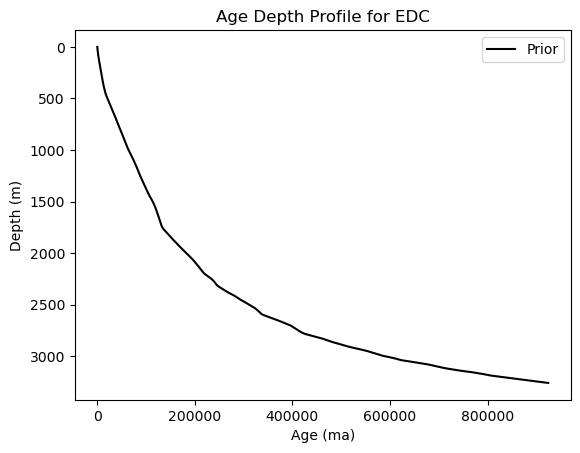

In [91]:
import matplotlib.pyplot as plt

l1, = plt.plot(accumulated_age, prior_output[core]["depth"], label="Prior", color='black')
#l2, = plt.plot(posterior_output[core]["age"], posterior_output[core]["depth"], label="Posterior", color='blue')
plt.title(f"Age Depth Profile for {core}")
plt.xlabel("Age (ma)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()